# Assignment 1

**INSTRUCTIONS:**

1. Write code to train unsmoothed unigram and bigram language models. We will use the provided corpora of train.txt (see Section 3).
2. Implement smoothing and unknown word handling (see Section 4).
3. Implement the Perplexity calculation (see Section 5)

**Getting started**
- I added the zip file `A1_DATASET.zip` to the files
- I dont think you can run shell scripts in the code block but you can run it in the `terminal` tab on the left

## Unigram and bigram probability computation

In [136]:
unigram_count = {}
bigram_count = {}
total_count = [0, 0]

with_pruning = 0
threshold = 17 # current pruning constant
UNK = "<UNK>"

with open("A1_DATASET/train.txt", "r") as file:
    line = file.readline()
    while line:
        tokens = line.split(" ")
        for index, token in enumerate(tokens):
            unigram_count[token] = unigram_count.get(token, 0) + 1
            total_count[0] += 1
            if index > 0:
                bigram_count[(tokens[index - 1], token)] = bigram_count.get((tokens[index - 1], token), 0) + 1
                total_count[1] += 1
        
        line = file.readline()

In [138]:
unigram_count[UNK] = 0

if with_pruning:
    for token, count in list(unigram_count.items()):
        if count < threshold and token != UNK:
            unigram_count[UNK] = unigram_count.get(UNK, 0) + count
            del unigram_count[token]

    for bigram, count in list(bigram_count.items()):
        if not bigram[0] in unigram_count and not bigram[1] in unigram_count:
            bigram_count[(UNK, UNK)] = bigram_count.get((UNK, UNK), 0) + count
        elif not bigram[0] in unigram_count:
            bigram_count[(UNK, bigram[1])] = bigram_count.get((UNK, bigram[1]), 0) + count
        elif not bigram[1] in unigram_count:
            bigram_count[(bigram[0], UNK)] = bigram_count.get((bigram[0], UNK), 0) + count

        if not bigram[0] in unigram_count or not bigram[1] in unigram_count:
            del bigram_count[bigram]

In [3]:
def prob_mle(count_unigram = None, count_bigram = None):
    if count_unigram is None:
        return None
    if count_bigram is None:
        return count_unigram / total_count[0]
    else:
       return count_bigram / count_unigram

In [4]:
import matplotlib.pyplot as plt

def create_graph(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10, 5))
    plt.bar(x, y, color="skyblue", edgecolor="black")

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=60)  # Rotate labels for readability

    # Show the plot
    plt.show()

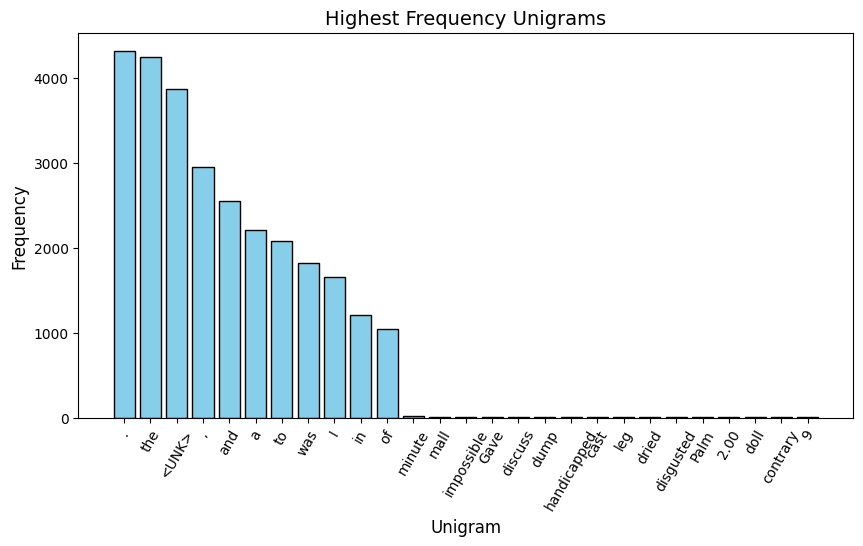

In [5]:
sorted_unigrams = sorted(unigram_count.items(), key=lambda x: x[1], reverse=True)
words, counts = zip(*(sorted_unigrams[:10] + sorted_unigrams[10:-10][::500] + sorted_unigrams[-10:])) 

create_graph(words, counts, "Highest Frequency Unigrams", "Unigram", "Frequency")

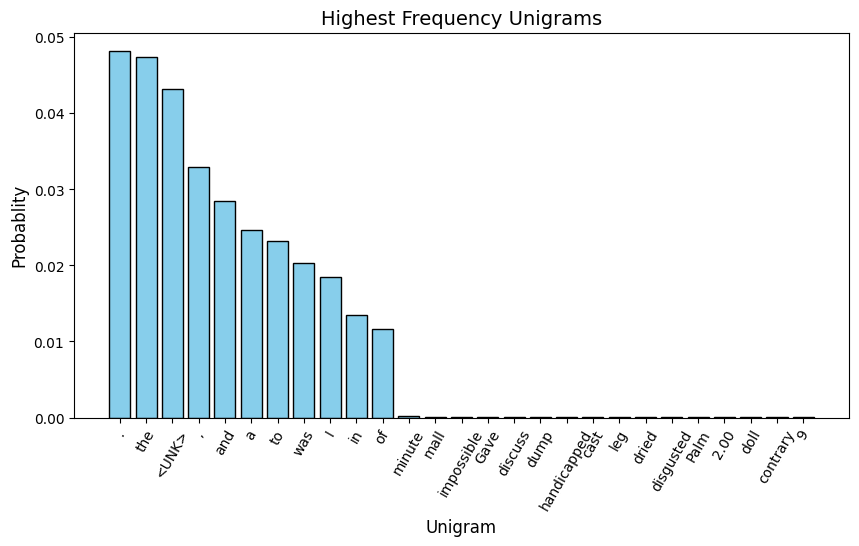

In [6]:
sorted_unigrams = sorted(unigram_count.items(), key=lambda x: x[1], reverse=True)
words, counts = zip(*(sorted_unigrams[:10] + sorted_unigrams[10:-10][::500] + sorted_unigrams[-10:])) 

create_graph(words, [prob_mle(count_unigram) for count_unigram in counts], "Highest Frequency Unigrams", "Unigram", "Probablity")

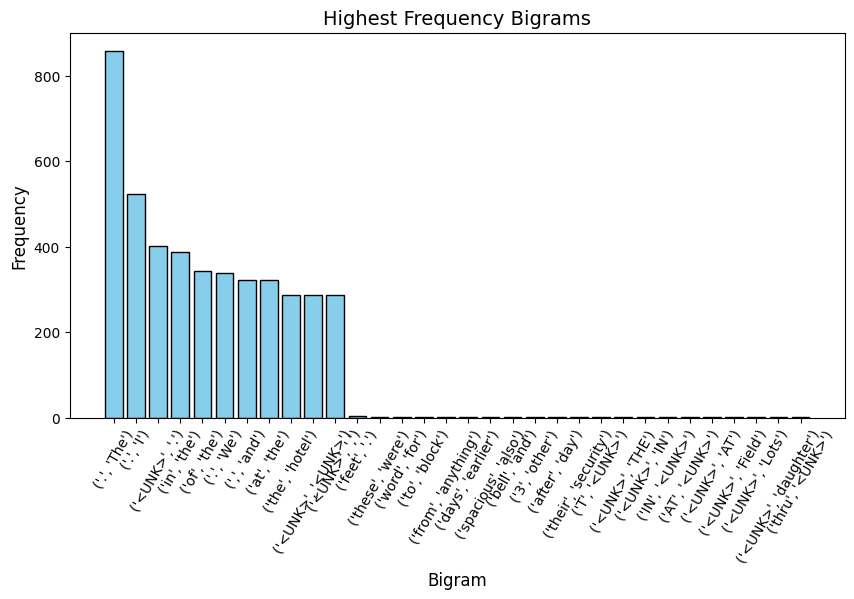

In [7]:
sorted_bigrams = sorted(bigram_count.items(), key=lambda x: x[1], reverse=True)
words, counts = zip(*(sorted_bigrams[:10] + sorted_bigrams[10:-10][::3000] + sorted_bigrams[-10:])) 

create_graph([str(word)for word in words], counts, "Highest Frequency Bigrams", "Bigram", "Frequency")

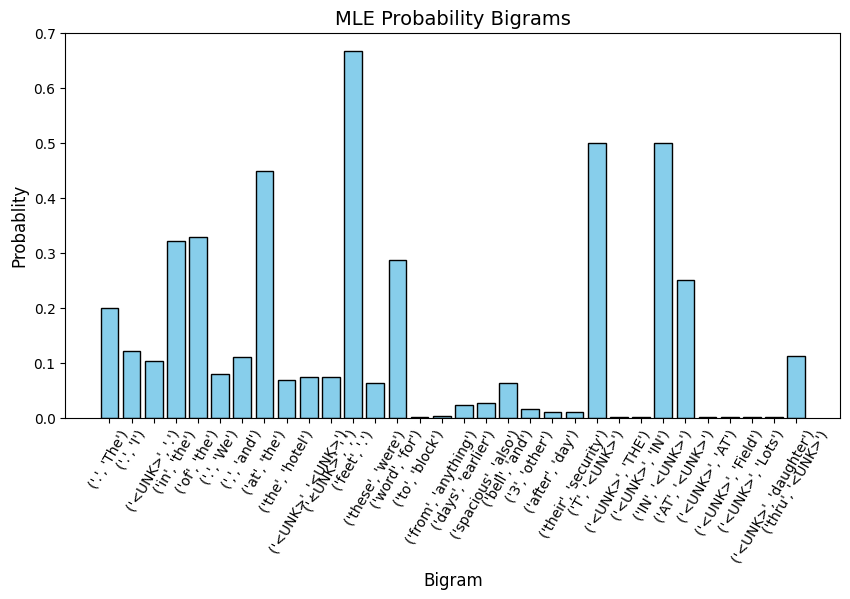

In [8]:
sorted_bigrams = sorted(bigram_count.items(), key=lambda x: x[1], reverse=True)
words, counts = zip(*(sorted_bigrams[:10] + sorted_bigrams[10:-10][::3000] + sorted_bigrams[-10:])) 

prob = []
for bigram, count_bigram in (sorted_bigrams[:10] + sorted_bigrams[10:-10][::3000] + sorted_bigrams[-10:]):
    prob.append(prob_mle(count_unigram=unigram_count[bigram[0]], count_bigram=count_bigram))

create_graph([str(word)for word in words], prob, "MLE Probability Bigrams", "Bigram", "Probablity")

## Implementation of Good-Turing smoothing

In [9]:
unigram_freg_count = {}
bigram_freq_count = {}
bigram_freq_count[0] = 1

for occ in unigram_count.values():
    unigram_freg_count[occ] = unigram_freg_count.get(occ, 0) + 1

for occ in bigram_count.values():
    bigram_freq_count[occ] = bigram_freq_count.get(occ, 0) + 1

def prob_good_t(count_unigram = None, count_bigram = None):
    if count_bigram != None:
        if (count_bigram + 1) in bigram_freq_count:
            return ((count_bigram + 1) * bigram_freq_count[count_bigram + 1] / 
                bigram_freq_count[count_bigram]) / total_count[1]
        return count_bigram / total_count[1]
    if count_unigram != None:
        if (count_unigram + 1) in unigram_freg_count:
            return ((count_unigram + 1) * unigram_freg_count[count_unigram + 1] / 
                unigram_freg_count[count_unigram]) / total_count[0]
        return count_unigram / total_count[0]

In [10]:
# def good_turing_smoothing(occ, count_count):
#     if (occ + 1) in count_count and occ in count_count and count_count[occ] > 0:
#         return (occ + 1) * count_count[occ + 1] / count_count[occ]
#     return occ

# smoothed_unigram_count = {}
# for token, count in unigram_count.items():
#     smoothed_count = good_turing_smoothing(count, gt_unigram_count_count)
#     smoothed_unigram_count[token] = smoothed_count

# # Create a function with count_unigram, count_bigram, can keep gt_unigram_count_count as arg
# # Then at 

# smoothed_bigram_count = {}
# for token, count in bigram_count.items():
#     smoothed_count = good_turing_smoothing(count, gt_bigram_count_count)
#     smoothed_bigram_count[token] = smoothed_count

# total_smoothed_unigram_count = sum(smoothed_unigram_count.values())
# total_smoothed_bigram_count = sum(smoothed_bigram_count.values())

# for token in smoothed_unigram_count.keys():
#     smoothed_unigram_count[token] /= total_smoothed_unigram_count

# for token in smoothed_bigram_count.keys():
#     smoothed_bigram_count[token] /= total_smoothed_bigram_count

# n1 = gt_bigram_count_count.get(1, 1)
# unseen_prob = n1 / total_smoothed_bigram_count

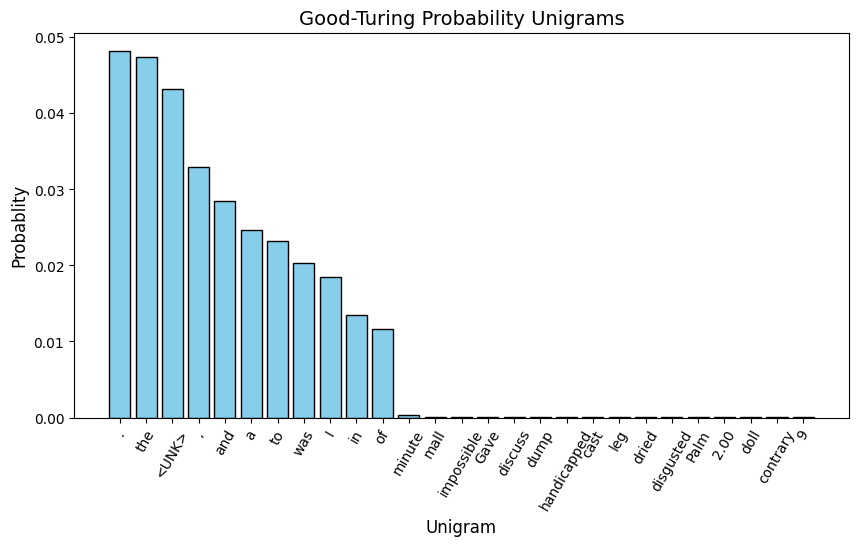

In [11]:
sorted_unigrams = sorted(unigram_count.items(), key=lambda x: x[1], reverse=True)
words, counts = zip(*(sorted_unigrams[:10] + sorted_unigrams[10:-10][::500] + sorted_unigrams[-10:])) 

create_graph(
    words, 
    [prob_good_t(count_unigram) for count_unigram in counts], 
    "Good-Turing Probability Unigrams", 
    "Unigram", 
    "Probablity")

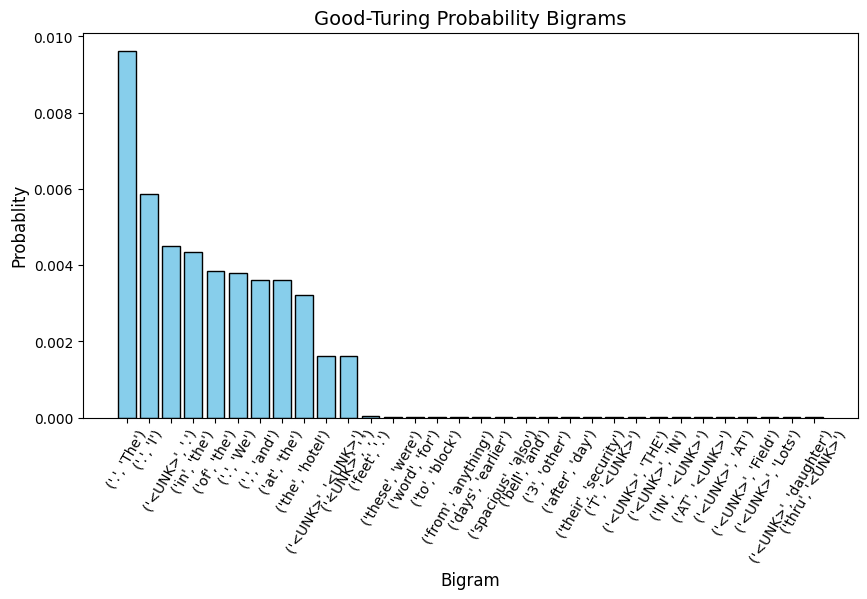

In [12]:
sorted_bigrams = sorted(bigram_count.items(), key=lambda x: x[1], reverse=True)
words, counts = zip(*(sorted_bigrams[:10] + sorted_bigrams[10:-10][::3000] + sorted_bigrams[-10:])) 

create_graph(
    [str(word) for word in words], 
    [prob_good_t(count_bigram=count_bigram) for count_bigram in counts], 
    "Good-Turing Probability Bigrams", 
    "Bigram", 
    "Probablity")

## Implementation of k-smoothing

In [140]:
vocab_size = len(unigram_count)

def prob_add_k(count_unigram = None, count_bigram = None, k = 1):
    if count_unigram is None:
        return None
    if count_bigram is None:
        return (count_unigram + k) / (total_count[0] + k * vocab_size)
    else:
       return (count_bigram + k) / (count_unigram + k * vocab_size) 

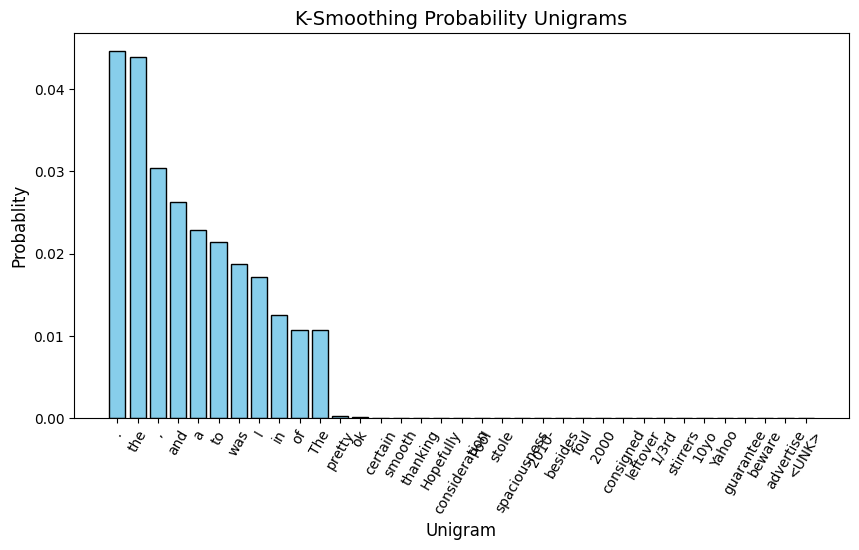

In [142]:
sorted_unigrams = sorted(unigram_count.items(), key=lambda x: x[1], reverse=True)
words, counts = zip(*(sorted_unigrams[:10] + sorted_unigrams[10:-10][::500] + sorted_unigrams[-10:])) 

create_graph(words, [prob_add_k(count_unigram, k=1) for count_unigram in counts], "K-Smoothing Probability Unigrams", "Unigram", "Probablity")

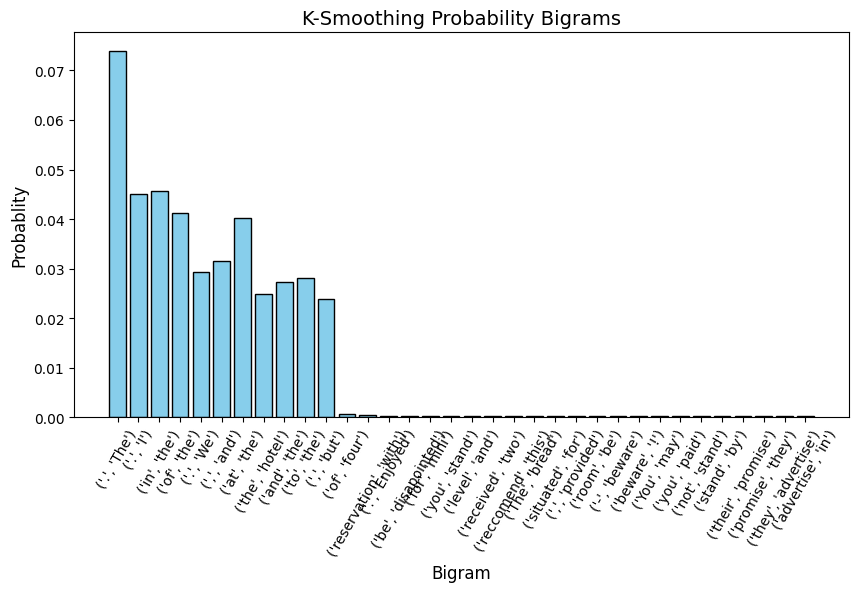

In [61]:
sorted_bigrams = sorted(bigram_count.items(), key=lambda x: x[1], reverse=True)
words, counts = zip(*(sorted_bigrams[:10] + sorted_bigrams[10:-10][::3000] + sorted_bigrams[-10:])) 

prob = []
for bigram, count_bigram in (sorted_bigrams[:10] + sorted_bigrams[10:-10][::3000] + sorted_bigrams[-10:]):
    prob.append(prob_add_k(count_unigram=unigram_count[bigram[0]], count_bigram=count_bigram, k=1))

create_graph([str(word)for word in words], prob, "K-Smoothing Probability Bigrams", "Bigram", "Probablity")

In [16]:
# k = .1  # current smoothing constant
# unigram_count_count = {}
# bigram_count_count = {}

# def k_smoothing(count, total_count, vocab_size, k):
#     return (count + k) / (total_count + k * vocab_size)

# vocab_size_unigrams = len(unigram_count)
# vocab_size_bigrams = len(bigram_count)

# total_unigram_count = sum(unigram_count.values())
# total_bigram_count = sum(bigram_count.values())

# smoothed_unigram_count = {}
# for token, count in unigram_count.items():
#     smoothed_count = k_smoothing(count, total_unigram_count, vocab_size_unigrams, k)
#     smoothed_unigram_count[token] = smoothed_count

# smoothed_bigram_count = {}
# for token, count in bigram_count.items():
#     smoothed_count = k_smoothing(count, total_bigram_count, vocab_size_bigrams, k)
#     smoothed_bigram_count[token] = smoothed_count

# total_smoothed_unigram_count = sum(smoothed_unigram_count.values())
# total_smoothed_bigram_count = sum(smoothed_bigram_count.values())

# for token in smoothed_unigram_count.keys():
#     smoothed_unigram_count[token] /= total_smoothed_unigram_count

# for token in smoothed_bigram_count.keys():
#     smoothed_bigram_count[token] /= total_smoothed_bigram_count

# n1 = bigram_count_count.get(1, 1)
# unseen_prob = n1 / total_smoothed_bigram_count


## Implementation of perplexity

In [17]:
import math
smoothing = 1e-4

def calculate_unigram_perplexity(unigram_count, prob_fn):
    total_log_prob = 0
    word_count = 0
    
    with open("/work/A1_DATASET/val.txt", "r") as file:
        line = file.readline()
        while line:
            tokens = line.split(" ")
            word_count += len(tokens)

            for token in tokens:
                if not token in unigram_count:
                    token = UNK
                prob = prob_fn(count_unigram = unigram_count[token])
                total_log_prob += math.log(prob)
            
            line = file.readline()

    perplexity = math.exp(-total_log_prob / word_count)
    return perplexity

In [18]:
def calculate_bigram_perplexity(unigram_count, bigram_count, prob_fn):
    total_log_prob = 0
    word_count = 0
    

    with open("/work/A1_DATASET/val.txt", "r") as file:
        line = file.readline()
        while line:
            tokens = line.split(" ")
            word_count += len(tokens)

            for i in range(1, len(tokens)):
                bigram = (tokens[i - 1], tokens[i])
                unigram = tokens[i - 1]

                prob = 0
                if not bigram[0] in unigram_count and not bigram[1] in unigram_count:
                    prob = prob_fn(
                        count_unigram = unigram_count[UNK], 
                        count_bigram = bigram_count.get((UNK, UNK), 0))
                elif not bigram[0] in unigram_count:
                    prob = prob_fn(
                        count_unigram = unigram_count[UNK], 
                        count_bigram = bigram_count.get((UNK, bigram[1]), 0))
                elif not bigram[1] in unigram_count:
                    prob = prob_fn(
                        count_unigram = unigram_count[unigram], 
                        count_bigram = bigram_count.get((bigram[0], UNK), 0))
                else:
                    prob = prob_fn(
                        count_unigram = unigram_count[unigram], 
                        count_bigram = bigram_count.get((bigram[0], bigram[1]), 0))
                    
                total_log_prob += math.log(prob)
            
            line = file.readline()

    perplexity = math.exp(-total_log_prob / word_count)
    return perplexity

In [130]:
add_k = lambda count_unigram, count_bigram = None: prob_add_k(count_unigram, count_bigram, k=0.001)
good_t = lambda count_unigram = None, count_bigram = None: prob_good_t(count_unigram, count_bigram)
prob_fn = add_k

perplexity = calculate_unigram_perplexity(unigram_count, prob_fn)
print(f"Unigram Perplexity: {perplexity}")

perplexity = calculate_bigram_perplexity(unigram_count, bigram_count, prob_fn)
print(f"Bigram Perplexity: {perplexity}")

Unigram Perplexity: 111.07329071081715
Bigram Perplexity: 52.279592403310794


In [160]:
k_values = [10 ** (24 * i / 100 - 6) for i in range(51)]
uni_perplexities = []
bi_perplexities = []

for k_value in k_values:
    add_k = lambda count_unigram, count_bigram = None: prob_add_k(count_unigram, count_bigram, k=k_value)
    uni_perplexities.append(calculate_unigram_perplexity(unigram_count, add_k))
    bi_perplexities.append(calculate_bigram_perplexity(unigram_count, bigram_count, add_k))

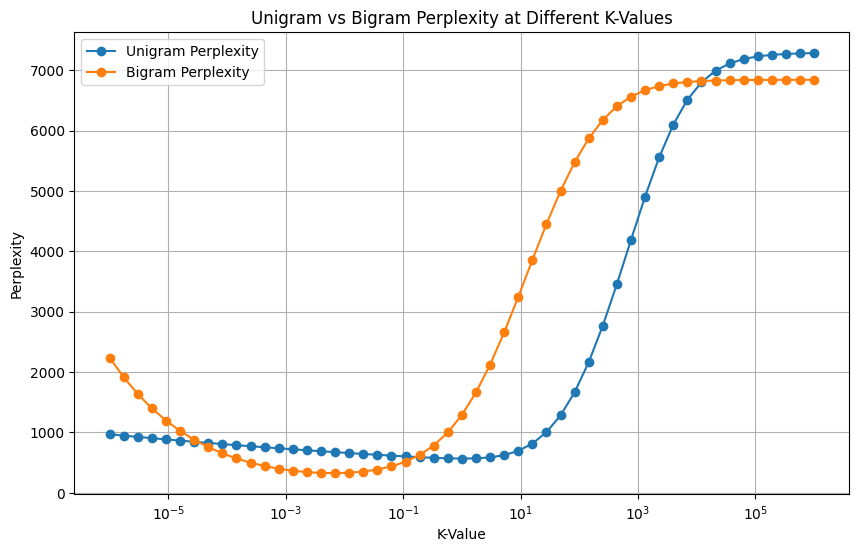

In [161]:
# Plot k-values vs perplexities
plt.figure(figsize=(10, 6))
plt.plot(k_values, uni_perplexities, label="Unigram Perplexity", marker='o', linestyle='-')
plt.plot(k_values, bi_perplexities, label="Bigram Perplexity", marker='o', linestyle='-')
plt.legend()
plt.xscale('log')  # Log scale for better visualization
plt.xlabel('K-Value')
plt.ylabel('Perplexity')
plt.title('Unigram vs Bigram Perplexity at Different K-Values')
plt.grid(True)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4cd1bb92-5c33-4c71-9500-71d9821d29e2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>